# Output scan(s) to a SPEC data file.

One of the common concerns is how to access data from bluesky's database.  The standard way is to replay the document stream from each of the scans through a bluesky callback that writes the data to the desired file format.  Here, we write data to the SPEC file format.

## Setup

First, we must setup a bluesky session.  We create a [temporary catalog](https://blueskyproject.io/databroker/how-to/file-backed-catalog.html?highlight=temporary#temporary-catalog) to store the data from this notebook's data collection.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.ion()

from bluesky import RunEngine, plans as bp
from bluesky.callbacks.best_effort import BestEffortCallback
import databroker

cat = databroker.temp()
RE = RunEngine({})
RE.subscribe(cat.v1.insert)
RE.subscribe(BestEffortCallback())

1

SPEC data files usually contain a list of all the motor positions at the start of each scan.  Starting with apstools release 1.6.11, it became possible to have the list of all ophyd-labeled `motor` devices logged to a separate stream at the start of every scan.  The next configuration will create a `label_start_motor` stream with the positions.  The `SpecWriterCallback` will find this stream and record the motor names and values in the `#O` and `#P` control lines, respectively.

In [2]:
from apstools.plans import label_stream_wrapper

def motor_start_preprocessor(plan):
    return label_stream_wrapper(plan, "motor", when="start")

RE.preprocessors.append(motor_start_preprocessor)

We need to create some scan data.  We'll use Gaussian peak profile calculated in a _userCalc_ (`swait` record) and a motor from our EPICS IOC simulator `gp:`.  Initialize the peak computation with some randomized parameters.  The peak will be at some `motor` position between -1 .. +1.  Print the actual values for our reference later on.

In [3]:
from apstools.devices import UserCalcN, setup_gaussian_swait
import numpy as np
from ophyd import EpicsMotor, EpicsSignal

IOC = "gp:"
motor = EpicsMotor(f"{IOC}m1", name="motor", labels=["motor"])
# define some extra motors to demonstrate #O & #P lines
omega = EpicsMotor(f"{IOC}m2", name="omega", labels=["motor"])
chi = EpicsMotor(f"{IOC}m3", name="chi", labels=["motor"])
phi = EpicsMotor(f"{IOC}m4", name="phi", labels=["motor"])
ttheta = EpicsMotor(f"{IOC}m5", name="ttheta", labels=["motor"])
atth = EpicsMotor(f"{IOC}m6", name="atth", labels=["motor"])
mx = EpicsMotor(f"{IOC}m7", name="mx", labels=["motor"])
my = EpicsMotor(f"{IOC}m8", name="my", labels=["motor"])
mz = EpicsMotor(f"{IOC}m9", name="mz", labels=["motor"])
swait = UserCalcN(f"{IOC}userCalc1", name="swait")
det = EpicsSignal(swait.calculated_value.pvname, name="det")

motor.wait_for_connection()
swait.wait_for_connection()
det.wait_for_connection()

setup_gaussian_swait(
    swait, motor.user_readback, 
    center=-0.5 + np.random.uniform(), 
    width=0.01 + 0.2*np.random.uniform(), 
    noise=0.05*(.95 + .1*np.random.uniform()),
    scale=100_000*(.95 + .1*np.random.uniform()), 
    )

print(f"calc = {swait.calculation.get()}")
print(f"A: x = {swait.channels.A.input_pv.get()}")
print(f"B: center = {swait.channels.B.input_value.get()}")
print(f"C: width = {swait.channels.C.input_value.get()}")
print(f"D: scale = {swait.channels.D.input_value.get()}")
print(f"E: noise= {swait.channels.E.input_value.get()}")


calc = D*(0.95+E*RNDM)/exp(((A-b)/c)^2)
A: x = gp:m1.RBV
B: center = 0.21141204623628096
C: width = 0.04939034587707944
D: scale = 102214.12035478499
E: noise= 0.05216222581266805


Finally, run the scan with the RunEngine:



Transient Scan ID: 1     Time: 2023-02-14 13:16:56
Persistent Unique Scan ID: '3df743d0-0768-467a-b5e8-1a4f84ad9c3d'
New stream: 'label_start_motor'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |        det |
+-----------+------------+------------+------------+
|         1 | 13:17:00.7 |   -1.20000 |    0.00000 |
|         2 | 13:17:01.1 |   -1.14000 |    0.00000 |
|         3 | 13:17:01.4 |   -1.08000 |    0.00000 |
|         4 | 13:17:01.7 |   -1.02000 |    0.00000 |
|         5 | 13:17:02.0 |   -0.96000 |    0.00000 |
|         6 | 13:17:02.3 |   -0.90000 |    0.00000 |
|         7 | 13:17:02.6 |   -0.84000 |    0.00000 |
|         8 | 13:17:02.9 |   -0.78000 |    0.00000 |
|         9 | 13:17:03.2 |   -0.72000 |    0.00000 |
|        10 | 13:17:03.5 |   -0.66000 |    0.00000 |
|        11 | 13:17:03.8 |   -0.60000 |    0.00000 |
|        12 | 13:17:04.1 |   -0.54000 |    0.00000 |
|        13 | 13:17:04.4 |   -0.

('3df743d0-0768-467a-b5e8-1a4f84ad9c3d',)

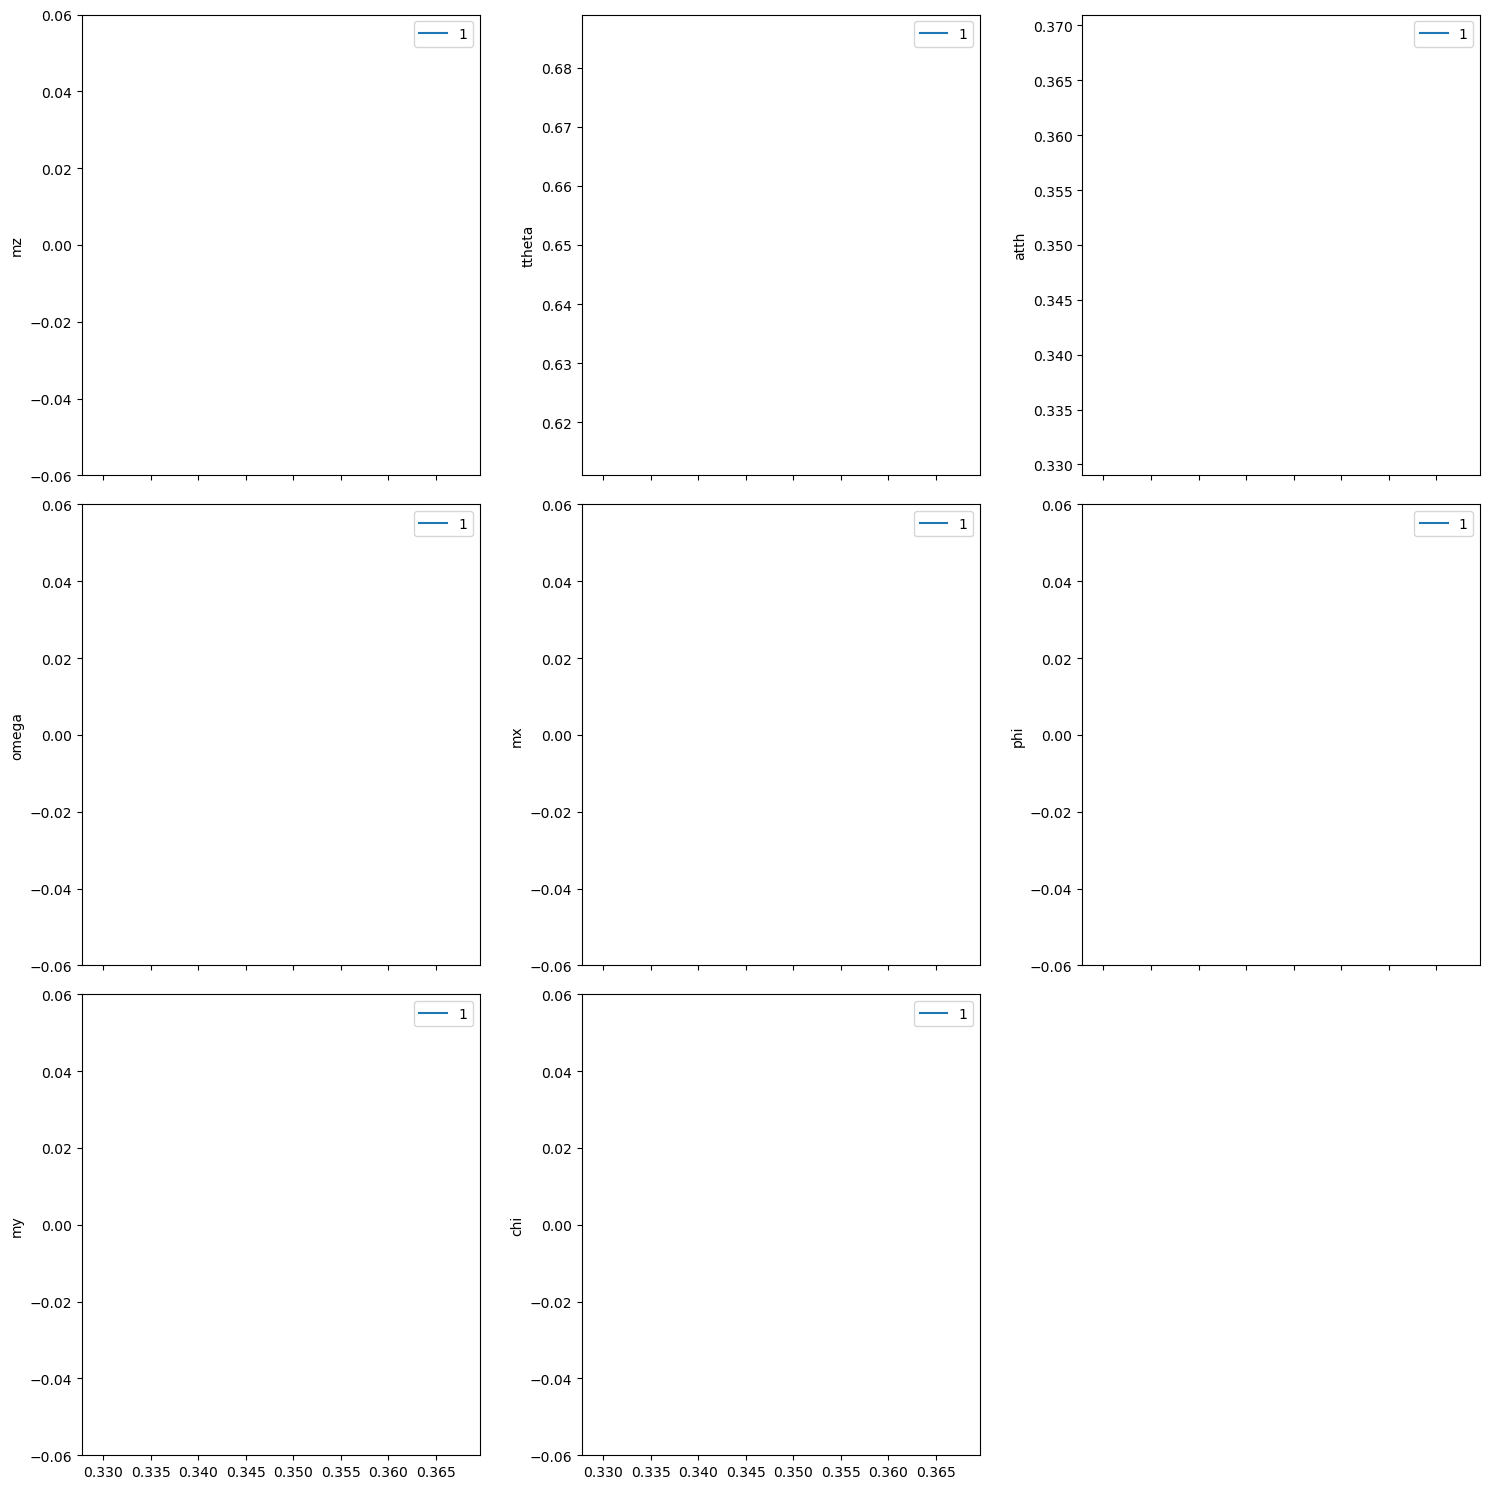

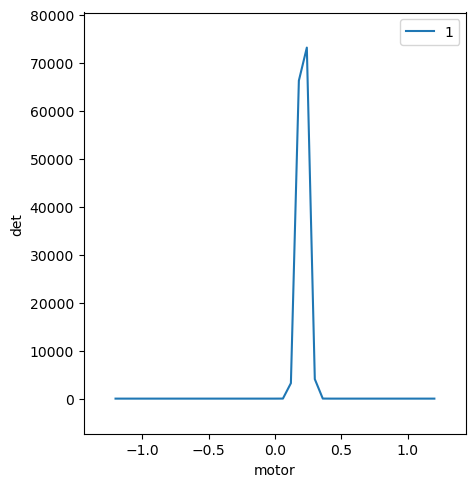

In [4]:
RE(bp.scan([det], motor, -1.2, 1.2, 41))

## get the most recent scan, by steps

The databroker instance, `cat`, provides access to its scans by several means.  One way is to consider `cat` as a list and retrieve the last item from the list.  This will return a *run*, the common reference to be used.

For this first example, we'll work through the steps one by one.  The `cat.v2` interface is the easiest to use (at this writing).

In [5]:
run = cat.v2[-1]
run

BlueskyRun
  uid='3df743d0-0768-467a-b5e8-1a4f84ad9c3d'
  exit_status='success'
  2023-02-14 13:16:56.441 -- 2023-02-14 13:17:12.871
  Streams:
    * label_start_motor
    * primary


As shown, the run has one data stream, name `primary`.  The databroker provides a simple table view of this run:

In [6]:
run.primary.read()

<xarray.Dataset>
Dimensions:              (time: 41)
Coordinates:
  * time                 (time) float64 1.676e+09 1.676e+09 ... 1.676e+09
Data variables:
    motor                (time) float64 -1.2 -1.14 -1.08 -1.02 ... 1.08 1.14 1.2
    motor_user_setpoint  (time) float64 -1.2 -1.14 -1.08 -1.02 ... 1.08 1.14 1.2
    det                  (time) float64 0.0 0.0 ... 3.032e-149 1.012e-169

## Support function: `specfile_example()`

We need to call the `apstools.callbacks.SpecWriterCallback()` callback with the run's documents.

Here, `specfile_example()` is a support function that can be used with one or more runs to create a SPEC data file (one Bluesky run will become one SPEC scan in the same file).

In [7]:
from apstools.callbacks import SpecWriterCallback
from databroker._drivers.mongo_normalized import BlueskyMongoCatalog
from databroker._drivers.msgpack import BlueskyMsgpackCatalog
import warnings

DEMO_SPEC_FILE = "test_specdata.txt"

def specfile_example(runs, filename=DEMO_SPEC_FILE):
    """write one or more headers (scans) to a SPEC data file"""
    if isinstance(runs, databroker.core.BlueskyRun):
        runs = [runs]
    if not isinstance(runs, (list, BlueskyMsgpackCatalog, BlueskyMongoCatalog)):
        raise TypeError("Must give run object or list of run objects.")
    if len(runs) == 0:
        raise ValueError("Must provide one or more runs.")

    specwriter = SpecWriterCallback(filename=filename, auto_write=True)
    for uid in runs:
        if isinstance(uid, str):
            run = runs[uid]
        else:
            run = uid
        if not isinstance(run, databroker.core.BlueskyRun):
            warnings.warn(f"Skipping {run=}, it is not a BlueskyRun object.")
            continue
        # to get the raw document stream, need the v1 interface
        h = run.catalog_object.v1[run.name]  # header
        for key, doc in h.db.get_documents(h):
            specwriter.receiver(key, doc)
        # lines = specwriter.prepare_scan_contents()
    print(f"Look at SPEC data file: {specwriter.spec_filename}")

## Write the run as SPEC data

Let's write it as a SPEC data file (namely: `spec1.dat`):

In [8]:
import pathlib

spec1_dat = pathlib.Path("spec1.dat")
if spec1_dat.exists():  # re-write the file
    spec1_dat.unlink()  # delete the existing file

specfile_example(run, filename=spec1_dat)

Look at SPEC data file: spec1.dat


Let's view file `spec1.dat` from disk storage (using the [`pycat`](https://ipython.readthedocs.io/en/stable/interactive/magics.html?highlight=pycat#magic-pycat) IPython magic function):

In [9]:
%pycat spec1.dat

#F spec1.dat
#E 1676402235
#D Tue Feb 14 13:17:15 2023
#C Bluesky  user = prjemian  host = zap
#O0 atth  chi  motor  mx  my  mz  omega  phi
#O1 ttheta
#o0 atth  chi  motor  mx  my  mz  omega  phi
#o1 ttheta

#S 1  scan(detectors=['det'], num=41, args='['motor', -1.2, 1.2]', per_step='None')
#D Tue Feb 14 13:16:56 2023
#C Tue Feb 14 13:16:56 2023.  plan_type = generator
#C Tue Feb 14 13:16:56 2023.  uid = 3df743d0-0768-467a-b5e8-1a4f84ad9c3d
#MD uid = 3df743d0-0768-467a-b5e8-1a4f84ad9c3d
#MD detectors = ['det']
#MD motors = ['motor']
#MD num_intervals = 40
#MD num_points = 41
#MD plan_pattern = inner_product
#MD plan_pattern_args = {'num': 41, 'args': ["EpicsMotor(prefix='gp:m1', name='motor', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu'])", -1.2, 1.2]}
#MD plan_pattern_module = bluesky.plan_patterns
#MD versions = {'ophyd': '1.7.0', 'bluesky': '1.10.0'}
#P0 0.

We see that the output of the `specfile_example()` command includes the content of the SPEC file.  For the remaining examples, we'll skip this additional step to view the SPEC file contents from disk.

## a specific scan

The `cat` object allows us to access scans by UUID (or any shorter version that remains unique in the database).  We show an example but have commented it out since those runs do not exist in our temporary databroker catalog.

In [10]:
# specfile_example(cat["37c188c0"], filename="spec3.dat")

## specify a list of scans by UID

Suppose we have a list of scans where we know the UID of each one, we can build a list of headers and write a SPEC data file with that list.  Here, we have such a list of tuning scans.  We show an example but have commented it out since those runs do not exist in our temporary databroker catalog.

In [11]:
# runs = [cat[uid] for uid in "957d83c c354fe37-e39f 42c".split()]
# specfile_example(runs, filename="spec_tunes.dat")

## Find specific plans within a range of dates

The `cat` object allows for filtering arguments based on any keywords in the *start* document and also by time.  Here, we filter between certain dates and also by `plan name`.  The dates are specified in [ISO8601 format](https://www.iso.org/iso-8601-date-and-time-format.html) and can include precision beyond a millisecond.  Here, we use the `v2` interface to do the searches.  We show examples how to pick between a set of dates.

Also, we write to the default data file: `test_specdata.txt`.

In [12]:
from databroker.queries import TimeRange
import datetime

test_specdata_txt = pathlib.Path("test_specdata.txt")
if test_specdata_txt.exists():  # will re-write the file
    test_specdata_txt.unlink()

query = {}
query.update(TimeRange(since="2019-02-19 17:00"))
query.update(TimeRange(until="2032-02-19 17:11:30"))
query.update(dict(plan_name="scan"))

runs = cat.v2.search(query)
for uid in runs:
    run = runs[uid]
    start_time = run.metadata["start"]["time"]
    isodate = datetime.datetime.fromtimestamp(start_time).isoformat(sep=" ")
    print(uid[:8], isodate)
specfile_example(runs, test_specdata_txt)

/home/prjemian/micromamba/envs/bluesky_2023_1/lib/python3.10/site-packages/databroker/queries.py:89: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  timezone = lz.zone


3df743d0 2023-02-14 13:16:56.441771
Look at SPEC data file: test_specdata.txt


In [13]:
%pycat test_specdata.txt

#F test_specdata.txt
#E 1676402235
#D Tue Feb 14 13:17:15 2023
#C Bluesky  user = prjemian  host = zap
#O0 atth  chi  motor  mx  my  mz  omega  phi
#O1 ttheta
#o0 atth  chi  motor  mx  my  mz  omega  phi
#o1 ttheta

#S 1  scan(detectors=['det'], num=41, args='['motor', -1.2, 1.2]', per_step='None')
#D Tue Feb 14 13:16:56 2023
#C Tue Feb 14 13:16:56 2023.  plan_type = generator
#C Tue Feb 14 13:16:56 2023.  uid = 3df743d0-0768-467a-b5e8-1a4f84ad9c3d
#MD uid = 3df743d0-0768-467a-b5e8-1a4f84ad9c3d
#MD detectors = ['det']
#MD motors = ['motor']
#MD num_intervals = 40
#MD num_points = 41
#MD plan_pattern = inner_product
#MD plan_pattern_args = {'num': 41, 'args': ["EpicsMotor(prefix='gp:m1', name='motor', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu'])", -1.2, 1.2]}
#MD plan_pattern_module = bluesky.plan_patterns
#MD versions = {'ophyd': '1.7.0', 'bluesky': '1.10.0'